# Exploratory data analysis HUPA-UCM Diabetes 
<br>**Participantes**<br>
- Morales Martinez Arturo 
- Moreno Santa Maria Luis Daniel

<br>**Dataset:**<br>
- Origen : Universidad de Madrid
<br>**Sensores:**<br>
- Freestle libre 2 for the Continuous Glucose Monitoring
- Fitbit Ionic smartwatches for the other variables (steps, calories, heartrate \& sleepdata)
<br>**Variables:**<br>
- time: time of data recording (yyyy-MM-dd’T’HH:mm:ss format)
- glucose: blood glucose value (mg/dL)
- calories: calories burned in the time Interval
- heart_rate: heart frequency
- steps: steps taken in the time interval
- basal_rate: basal insulin infusions in the time interval
- bolus_volume_delivered: insulin bolus injections in the time interval
- carb_input: servings of carbohydrates ingested in the time interval (1 serving = 10 g)

## Libraries & Configuration

In [25]:
# Miscellaneous Funcionality
import os, glob
import re

# ETL
import numpy as np
import pandas as pd


# Visualization
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns

# Math
import scipy.stats as stats

In [2]:
# plot customization
sns.set_theme()
width = 6.3 # 21cm - 5cm = 16 cm = 6.3 inches
flierprops = dict(marker = "+", color = "r")

In [3]:
data_dir = 'HUPA-UCM Diabetes Dataset/Preprocessed'

## Exploratory Data Analysis

### Preprocessed data

In [4]:
# Append all the patients onto a single dataframe
people = []
path = "HUPA-UCM Diabetes Dataset/Preprocessed/"
for filename in glob.glob(os.path.join(path, '*.csv')):
    df = pd.read_csv(filename, sep = ";")
    df["time"] = df["time"].apply(lambda x: np.datetime64(x))
    people.append(df)

#### Rows per pacient

In [5]:
# Find patient's number
def find_number_string(string):
    numbers = re.findall(r'\d+', string)
    return numbers

In [6]:
# The following cell is intended to get a dictionary where each key is the patient's id amd the value the number of rows 
patients = {int(find_number_string(os.path.join(data_dir, filename))[0]) : pd.read_csv(os.path.join(data_dir, filename), sep=';').shape[0]
                   for filename in os.listdir(data_dir)}

# Just to sort by the amount of rows
patients = dict(sorted(patients.items(), key=lambda item: item[1]))

In [7]:
# Now, just tabulate days, months and year per patient
table = [] 
for key, value in patients.items():
    days = value / 288
    months = days / 30
    years = months / 12
    table.append([key, value, days, months, years])
print(tabulate(table, headers=["Patient", "Rows", "Days", "Months", "Years"], tablefmt="grid"))

+-----------+--------+-----------+-----------+-----------+
|   Patient |   Rows |      Days |    Months |     Years |
+===========+========+===========+===========+===========+
|         6 |   2290 |   7.95139 |  0.265046 | 0.0220872 |
+-----------+--------+-----------+-----------+-----------+
|        21 |   2343 |   8.13542 |  0.271181 | 0.0225984 |
+-----------+--------+-----------+-----------+-----------+
|        20 |   2862 |   9.9375  |  0.33125  | 0.0276042 |
+-----------+--------+-----------+-----------+-----------+
|        24 |   2902 |  10.0764  |  0.33588  | 0.02799   |
+-----------+--------+-----------+-----------+-----------+
|        10 |   2976 |  10.3333  |  0.344444 | 0.0287037 |
+-----------+--------+-----------+-----------+-----------+
|         2 |   3181 |  11.0451  |  0.368171 | 0.0306809 |
+-----------+--------+-----------+-----------+-----------+
|         4 |   3184 |  11.0556  |  0.368519 | 0.0307099 |
+-----------+--------+-----------+-----------+----------

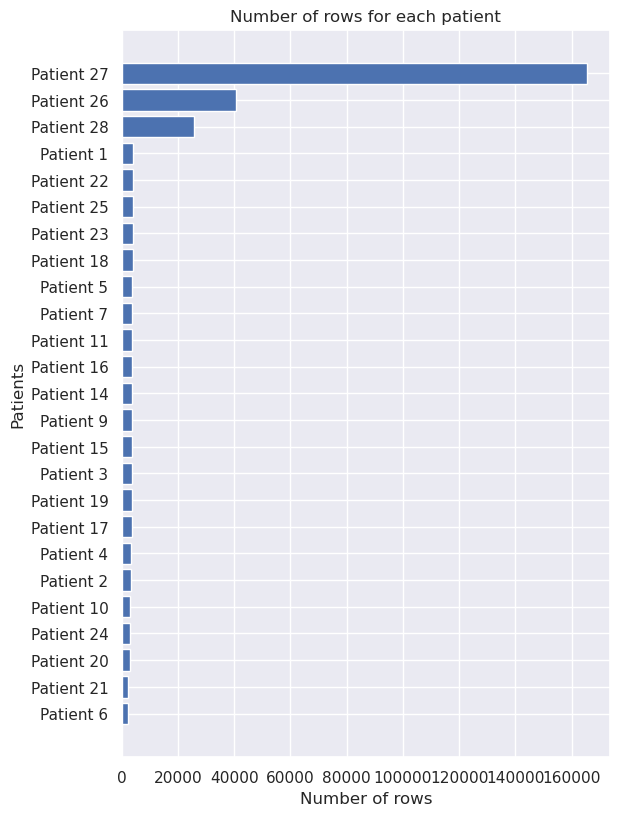

In [8]:
plt.figure(figsize=(width, width + width/2))
plt.barh([f'Patient {key}' for key, value in patients.items()], [value for key, value in patients.items()])
plt.xlabel('Number of rows')
plt.ylabel('Patients')
plt.grid(True)
plt.title('Number of rows for each patient')
plt.savefig('Images/Number_rows_by_patient')

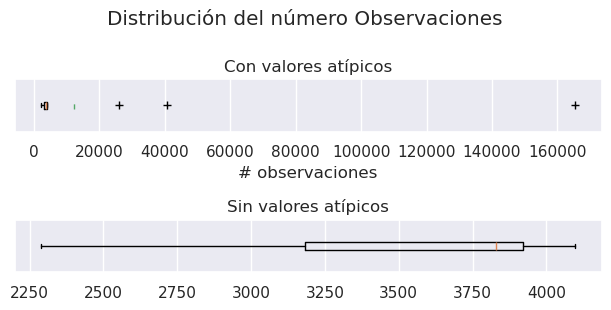

In [10]:
lengths = [len(person) for person in people]
fig, axs = plt.subplots(2, 1, figsize = (width,width/2))
axs[0].boxplot(lengths, showfliers = True, orientation = "horizontal",showbox = True, flierprops = flierprops, showmeans = True, meanline = True)
axs[0].set_xlabel("# observaciones")
axs[0].set_yticks([])
axs[0].set_title("Con valores atípicos") # Atipycal values : v > Q3 + 1.5 RIC 
axs[1].boxplot(lengths, showfliers = False, orientation = "horizontal",showbox = True, flierprops = flierprops)
axs[1].set_yticks([])
axs[1].set_title("Sin valores atípicos")
plt.suptitle("Distribución del número Observaciones")
plt.tight_layout()
plt.show()

#### Relations Between Variables

In [34]:
glucose.max() - glucose.min()

302.0

In [39]:
2 * iqr * (len(glucose)) ** (1/3)

np.float64(2468.7621862112596)

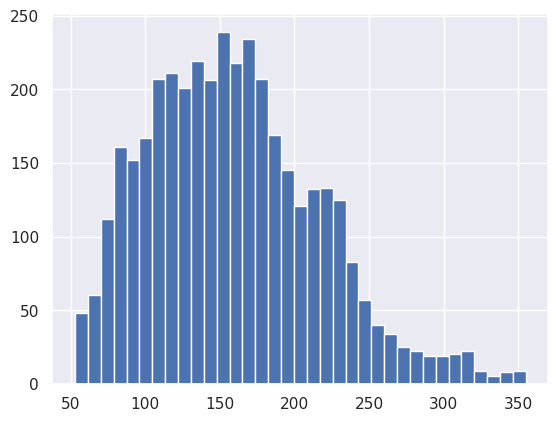

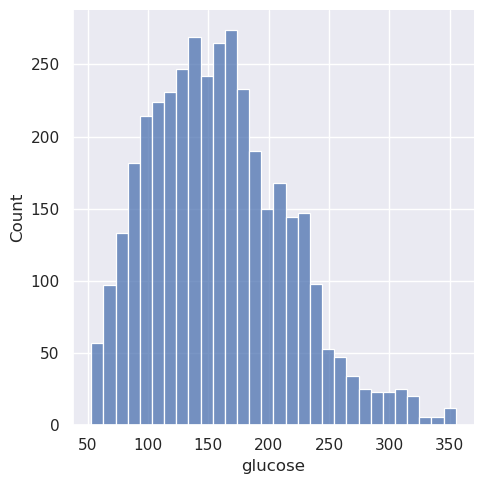

In [40]:
# Glucose distribution
glucose = df["glucose"]
#iqr = stats.iqr(glucose)
# bins are calculated Freedman–Diaconis rule
#bins = (glucose.max() - glucose.min()) / (2 * iqr * ((len(glucose)) ** (1/3)))
plt.hist(glucose, bins = 35)
sns.displot(glucose)

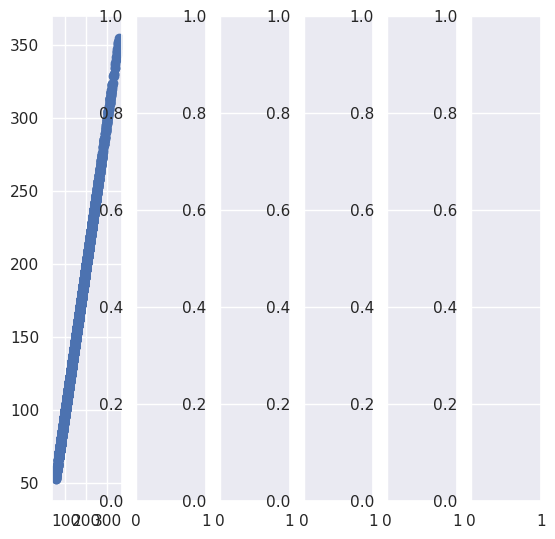

In [41]:
ig, axs = plt.subplots(1, 6, figsize = (width, width))
axs[0].scatter(glucose, glucose)